- number of nodes
- number of continuity groups
- filter non-planarity artifacts
- CES counts
- prime detection
- crosses detection
- touches detecion

## To-do:

- Post-processing step snapping nearby nodes together. In case of clusters, do that iteratively.
- Ensure we preserve attributes and mark our changes

In [1]:
import logging

import geopandas as gpd
import matplotlib.pyplot as plt
import momepy
import numpy as np
import pandas as pd
from libpysal import graph
from scipy import sparse

from core import algorithms, utils


Set logging level to debug to see the debugging messages.

In [2]:
logging.basicConfig(level=logging.DEBUG)

Specify case metadata

In [3]:
case = "Liège"

Read road data

In [4]:
roads = utils.read_original(case)

Remove duplicated roads

In [5]:
roads = momepy.remove_false_nodes(roads)
roads = roads[~roads.geometry.duplicated()].reset_index()
roads = momepy.remove_false_nodes(roads)

Assign COINS-based information to roads

In [6]:
# %%time
roads, coins = algorithms.common.continuity(roads)

Read artifacts

In [7]:
artifacts = momepy.FaceArtifacts(roads).face_artifacts.set_crs(roads.crs)
artifacts["id"] = artifacts.index

Remove edges fully within the artifact (dangles).

In [8]:
a_idx, _ = roads.sindex.query(artifacts.geometry, predicate="contains")
artifacts = artifacts.drop(artifacts.index[a_idx])

Get nodes from the network.

In [9]:
nodes = momepy.nx_to_gdf(momepy.node_degree(momepy.gdf_to_nx(roads)), lines=False)

Link nodes to artifacts

In [10]:
node_idx, artifact_idx = artifacts.sindex.query(
    nodes.buffer(0.1), predicate="intersects"
)
intersects = sparse.coo_array(
    ([True] * len(node_idx), (node_idx, artifact_idx)),
    shape=(len(nodes), len(artifacts)),
    dtype=np.bool_,
)

Compute number of nodes per artifact

In [11]:
artifacts["node_count"] = intersects.sum(axis=0)

Apply additional filters to remove artifacts that are not suitable for simplification. These may be artifacts that:
- are too large in size
- are part of a larger intersection that may need different methods of simplification

In [12]:
area_threshold = 1250  # this is hard to determine but it can be done iteratively using different thresholds
circular_compactness_threshold = 0.15  # same as above

rook = graph.Graph.build_contiguity(artifacts, rook=True)

# keep only those artifacts which occur as isolates, i.e. are not part of a larger intersection
artifacts = artifacts.loc[artifacts.index.intersection(rook.isolates)]

Compute number of stroke groups per artifact

In [13]:
strokes, c_, e_, s_ = algorithms.common.get_stroke_info(artifacts, roads)

artifacts["stroke_count"] = strokes
artifacts["C"] = c_
artifacts["E"] = e_
artifacts["S"] = s_

Filter artifacts caused by non-planar intersections. (Note that this is not perfect and some 3CC artifacts were non-planar but not captured here).

In [14]:
artifacts["non_planar"] = artifacts["stroke_count"] > artifacts["node_count"]
a_idx, r_idx = roads.sindex.query(artifacts.geometry.boundary, predicate="overlaps")
artifacts.iloc[np.unique(a_idx), -1] = True

Count intersititial nodes (primes).

In [15]:
artifacts["interstitial_nodes"] = artifacts.node_count - artifacts[["C", "E", "S"]].sum(
    axis=1
)

Define the type label.

In [16]:
ces_type = []
for x in artifacts[["node_count", "C", "E", "S"]].itertuples():
    ces_type.append(f"{x.node_count}{'C' * x.C}{'E' * x.E}{'S' * x.S}")
artifacts["ces_type"] = ces_type

Explore typology.

In [17]:
# ces = "3CC"
#
# m = roads.explore(
#     "coins_len",
#     k=20,
#     scheme="quantiles",
#     tiles="cartodb positron",
#     prefer_canvas=True,
#     name="Roads",
#     highlight_kwds={"color": "red"},
#     style_kwds=dict(weight=5),
#     max_zoom=52,
#     opacity=0.5,
# )
# artifacts[artifacts.ces_type == ces].explore(m=m, name="Artifacts", color="red")
# nodes.explore(m=m, name="Nodes", color="blue", marker_size=250)
# folium.LayerControl().add_to(m)
# plugins.MousePosition().add_to(m)

# m

Optionally define a subset of data.

In [18]:
data_sample = artifacts.sample(50)

Simplify singleton artifacts.

In [19]:
new_roads = algorithms.simplify.simplify_singletons(data_sample, roads, nodes)

DEBUG:root:FUNCTION n1_g1_identical
/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
DEBUG:root:FUNCTION nx_gx_identical
DEBUG:root:FUNCTION nx_gx
DEBUG:root:CONDITION is_loop True
/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
DEBUG:root:FUNCTION nx_gx
DEBUG:root:CONDITION n_comps > 1 True
DEBUG:root:CONDITION relevant_targets.shape[0] > 0 False, snapping to C
DEBUG:root:CONDITION remaining_nodes.shape[0] < 2 False
/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
DEBUG:root:FUNCTION nx_gx
DEBUG:root:CONDITION is_loop True
/

Visual exploration of the result.

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
DEBUG:matplotlib.font_manager:findfont: score(FontEntry

6872


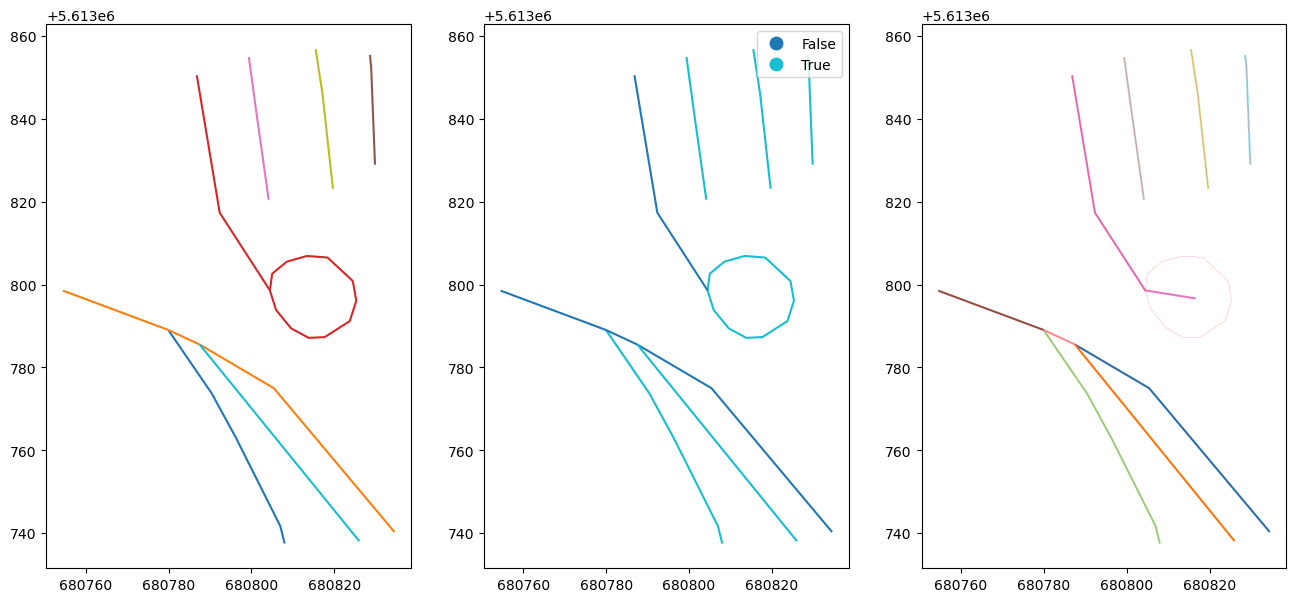

4720


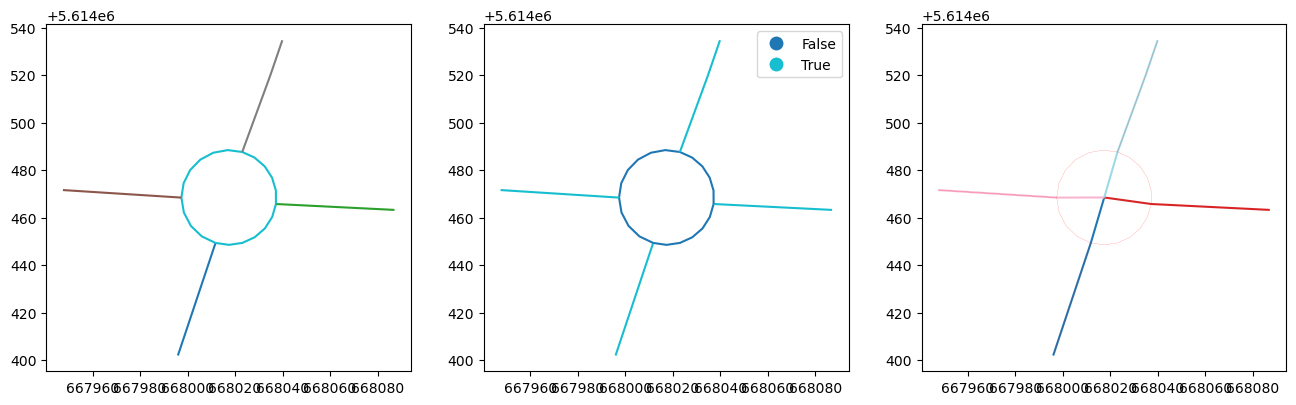

4433


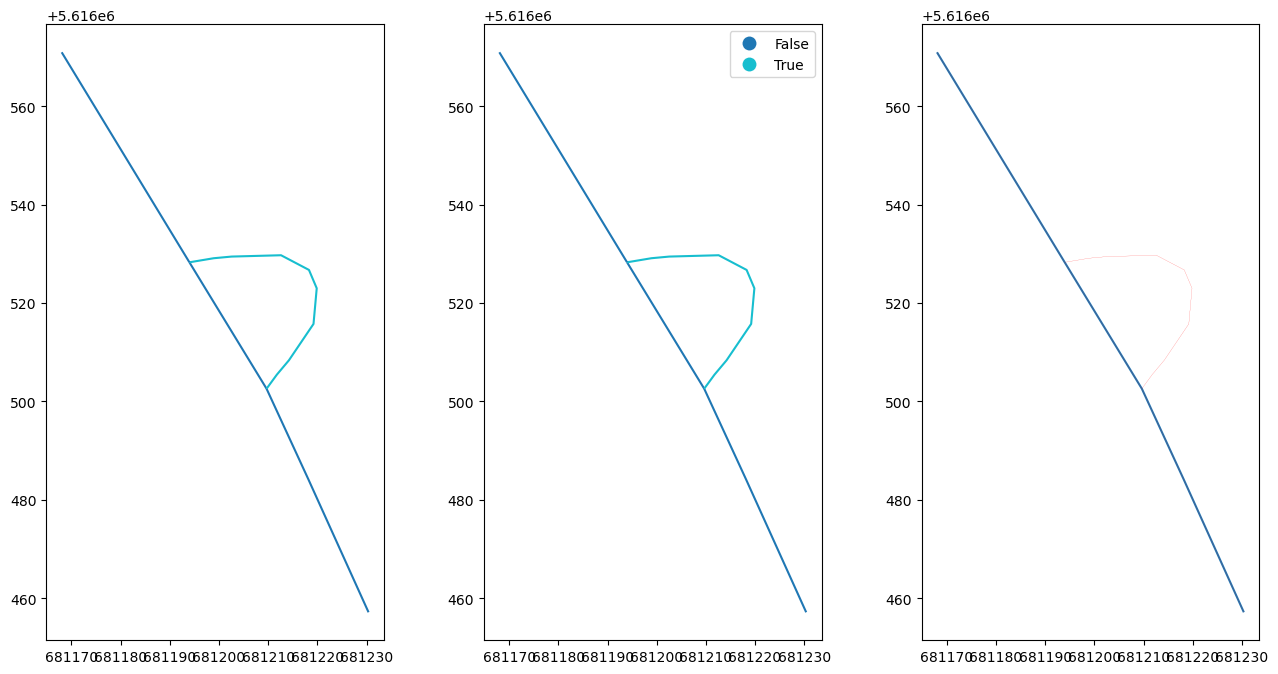

3583


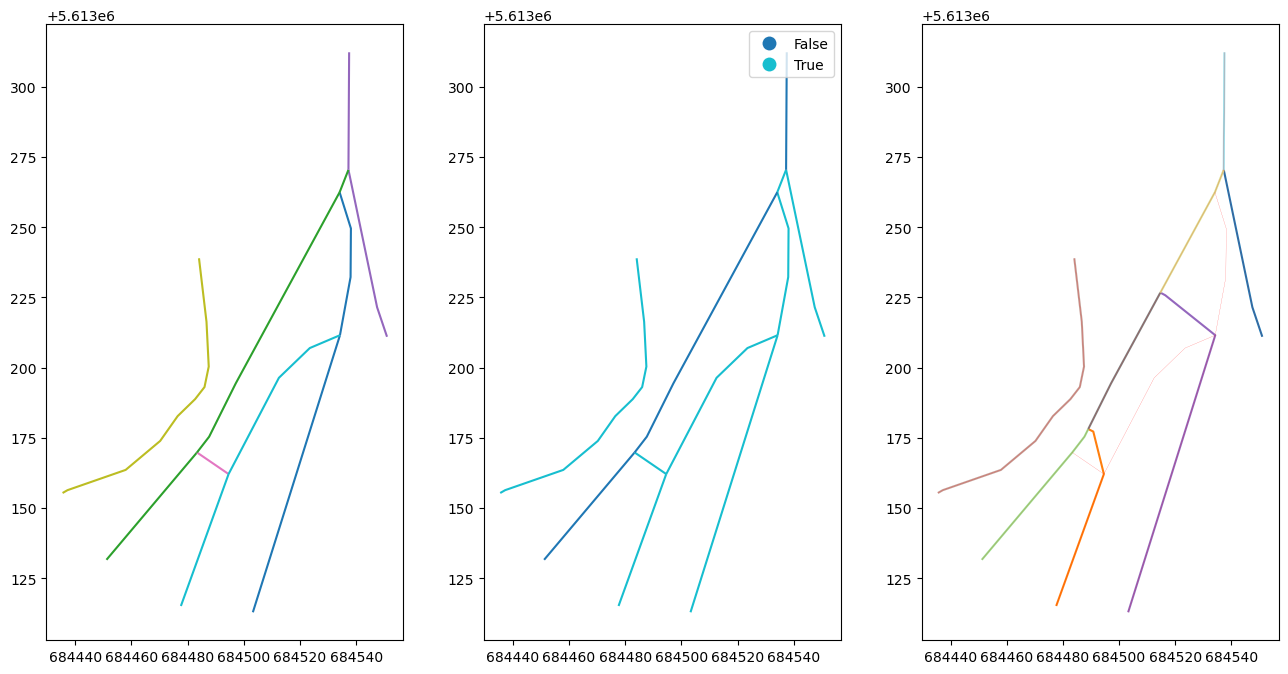

4460


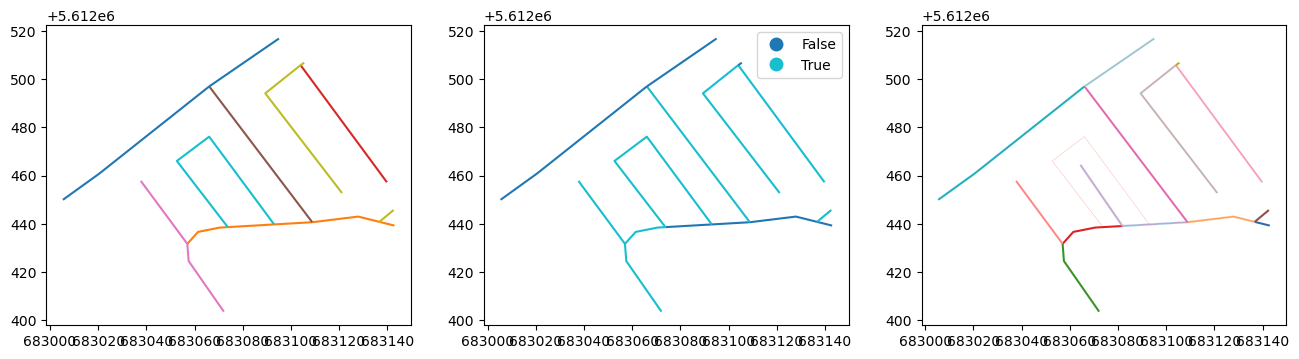

5697


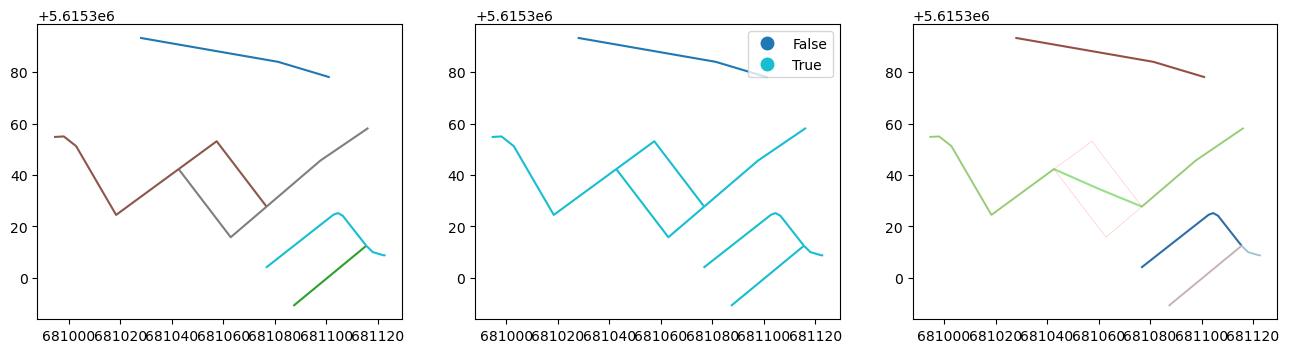

6314


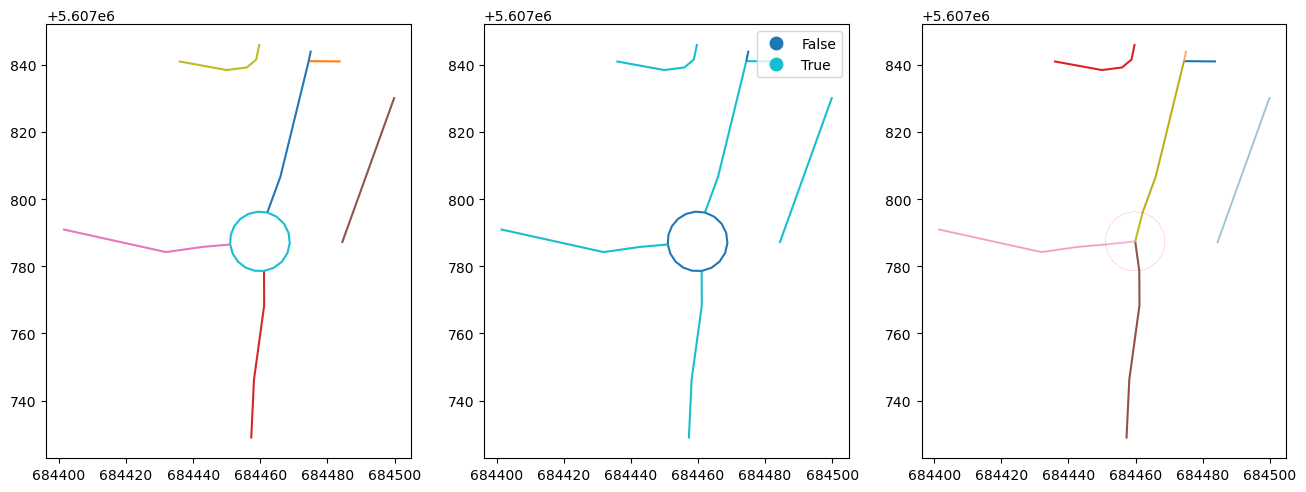

6571


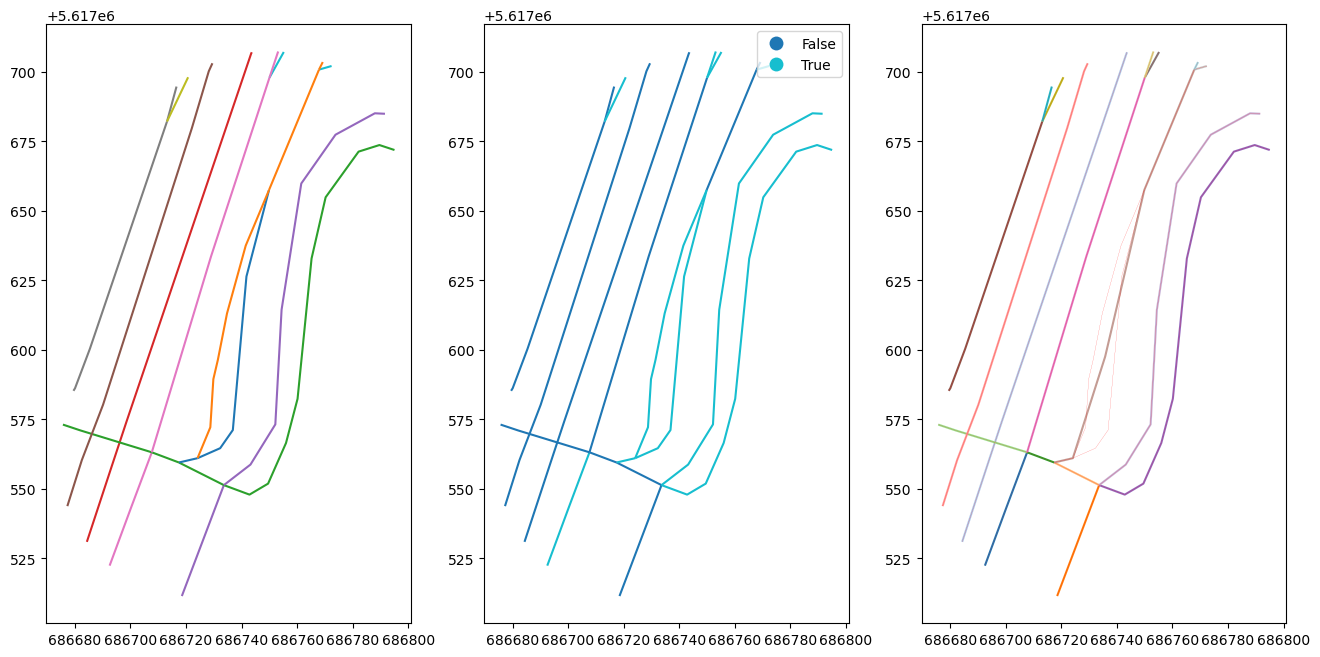

4757


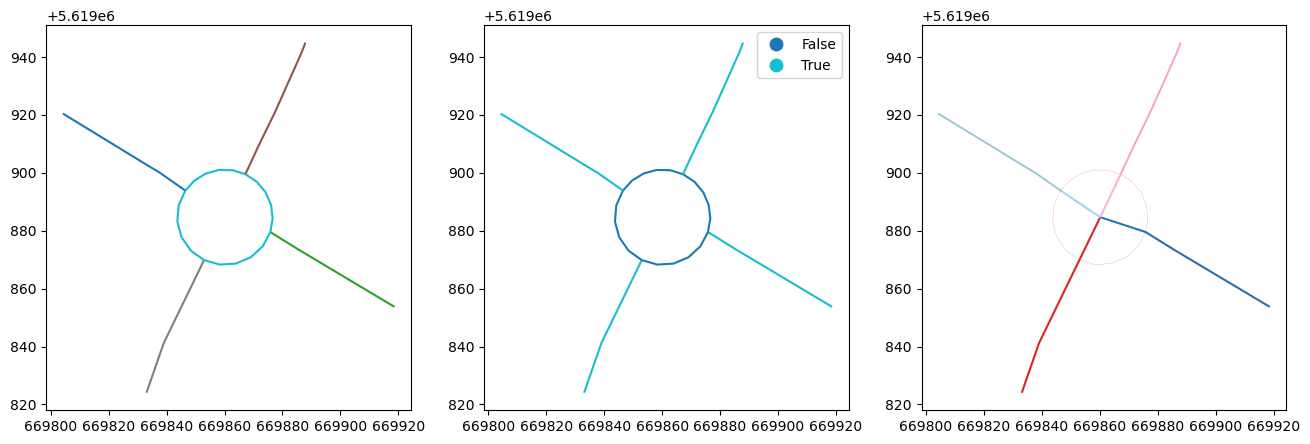

6878


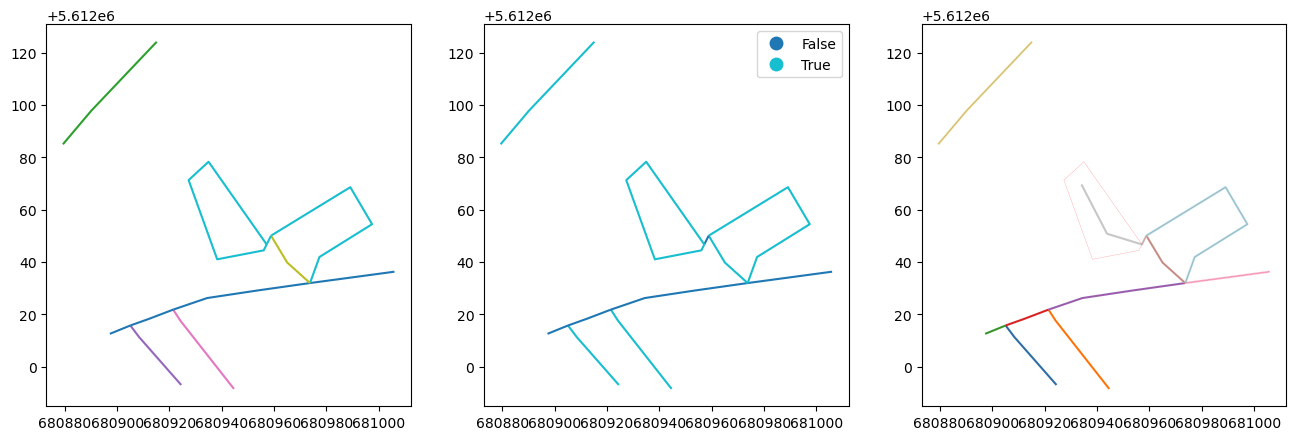

1189


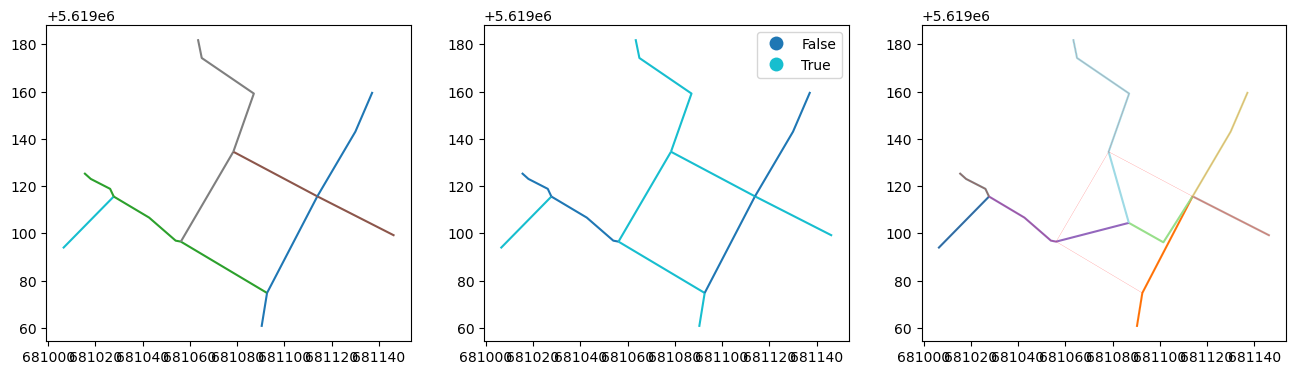

2050


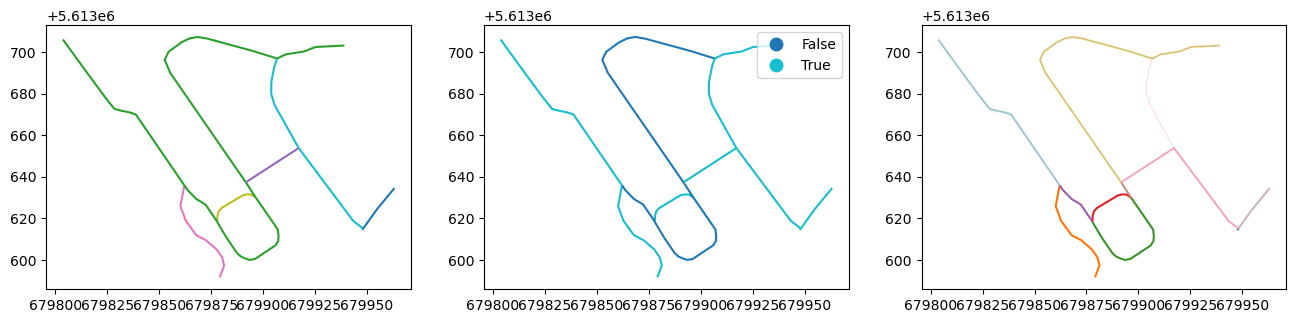

5802


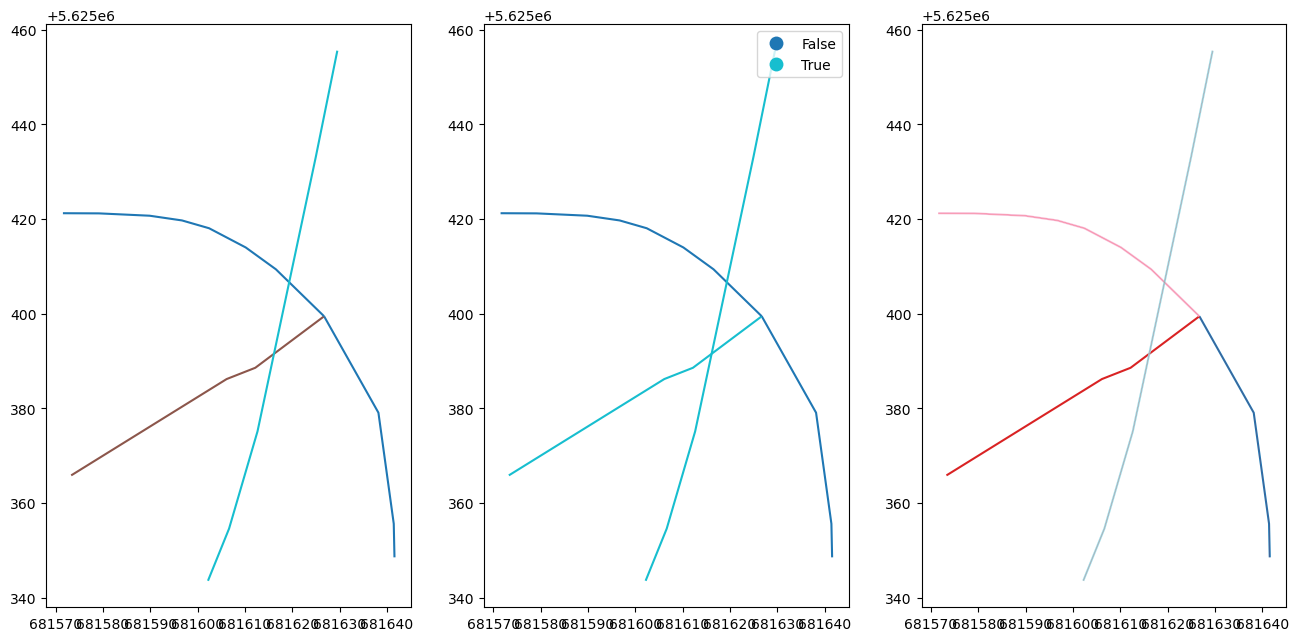

5527


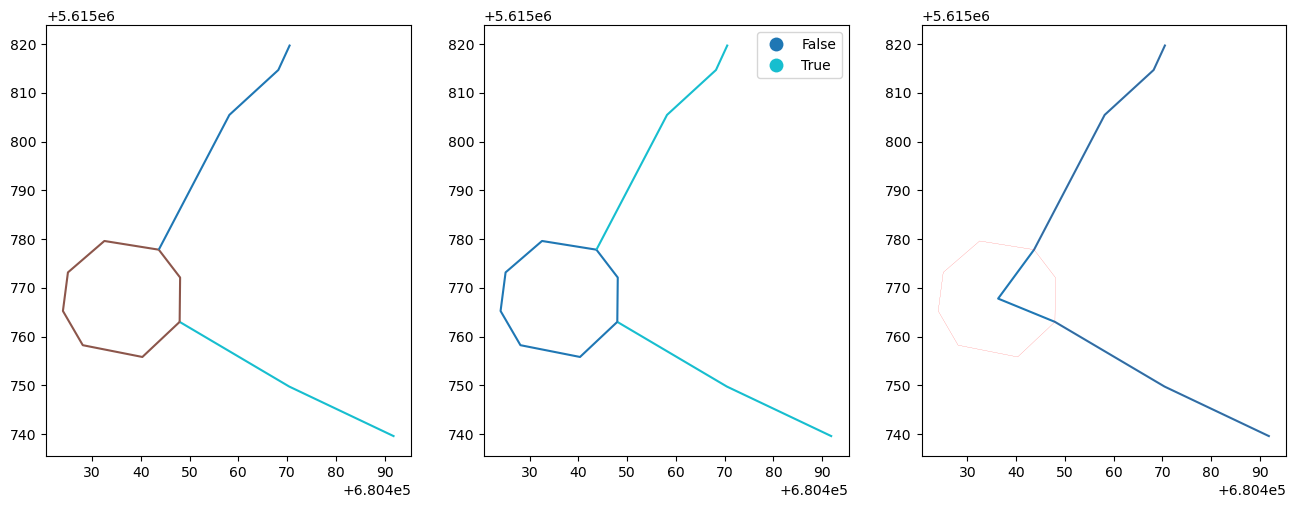

930


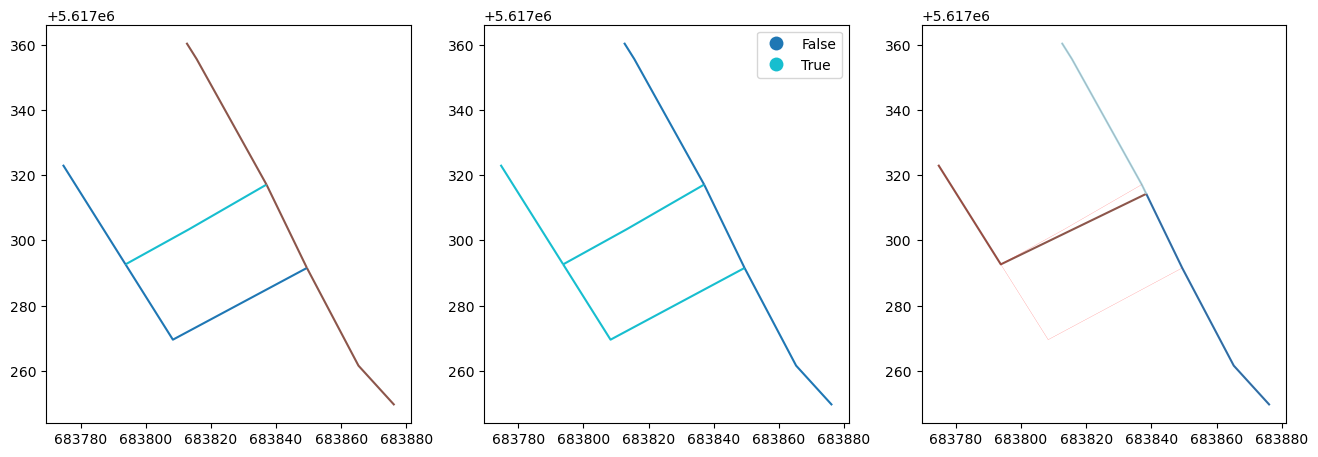

4100


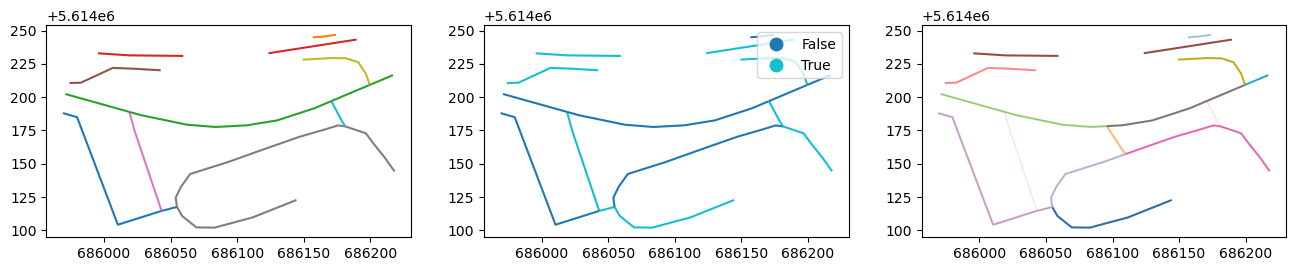

6881


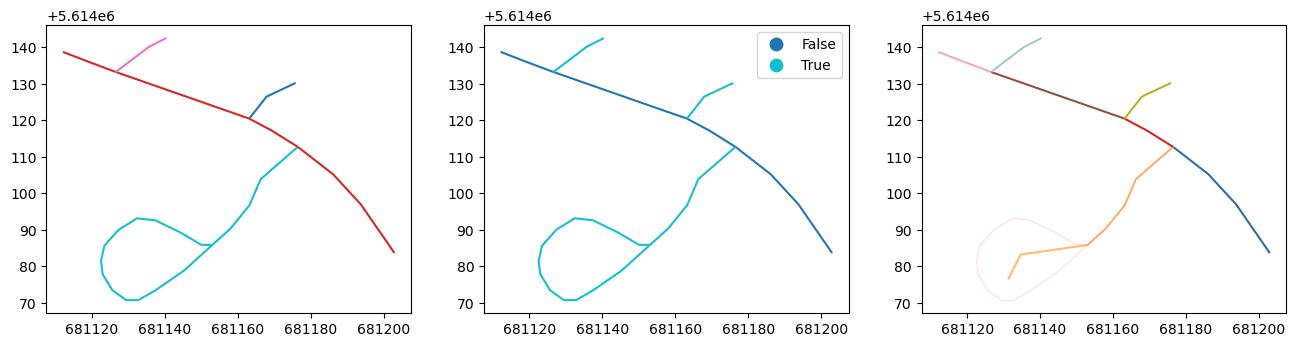

3977


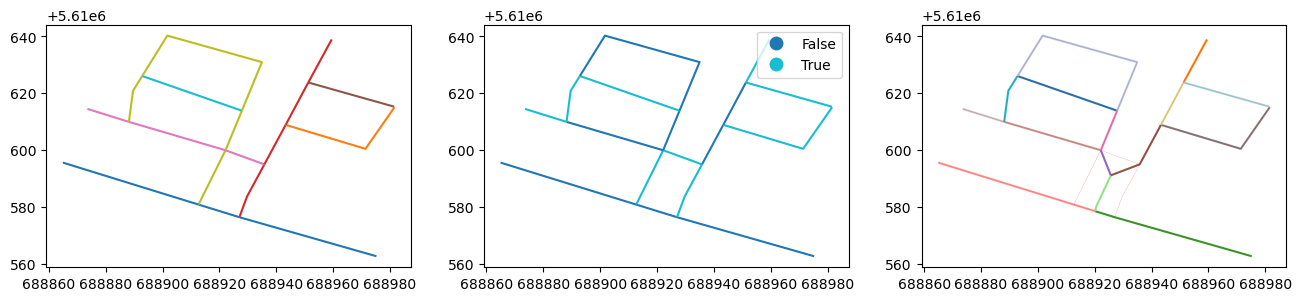

6483


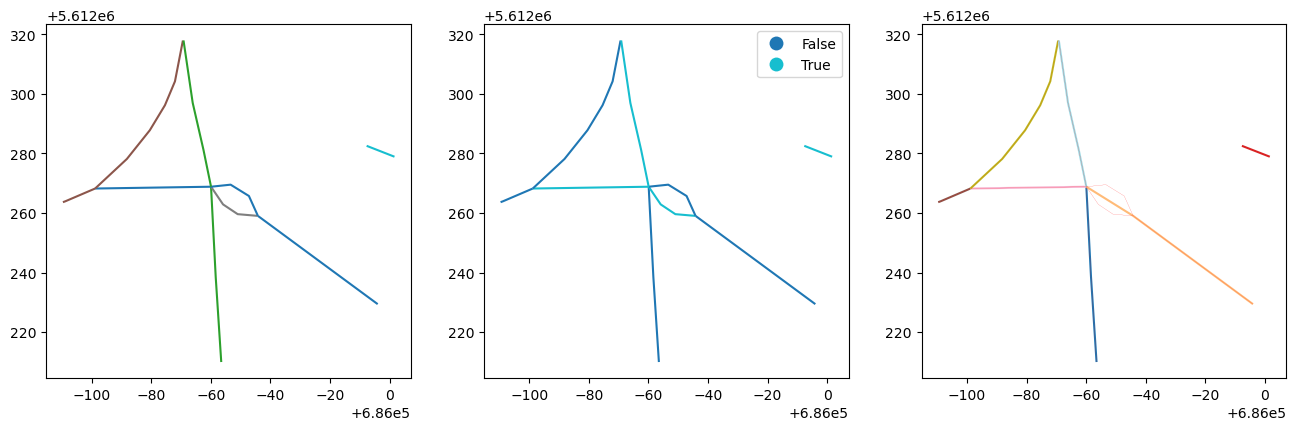

6829


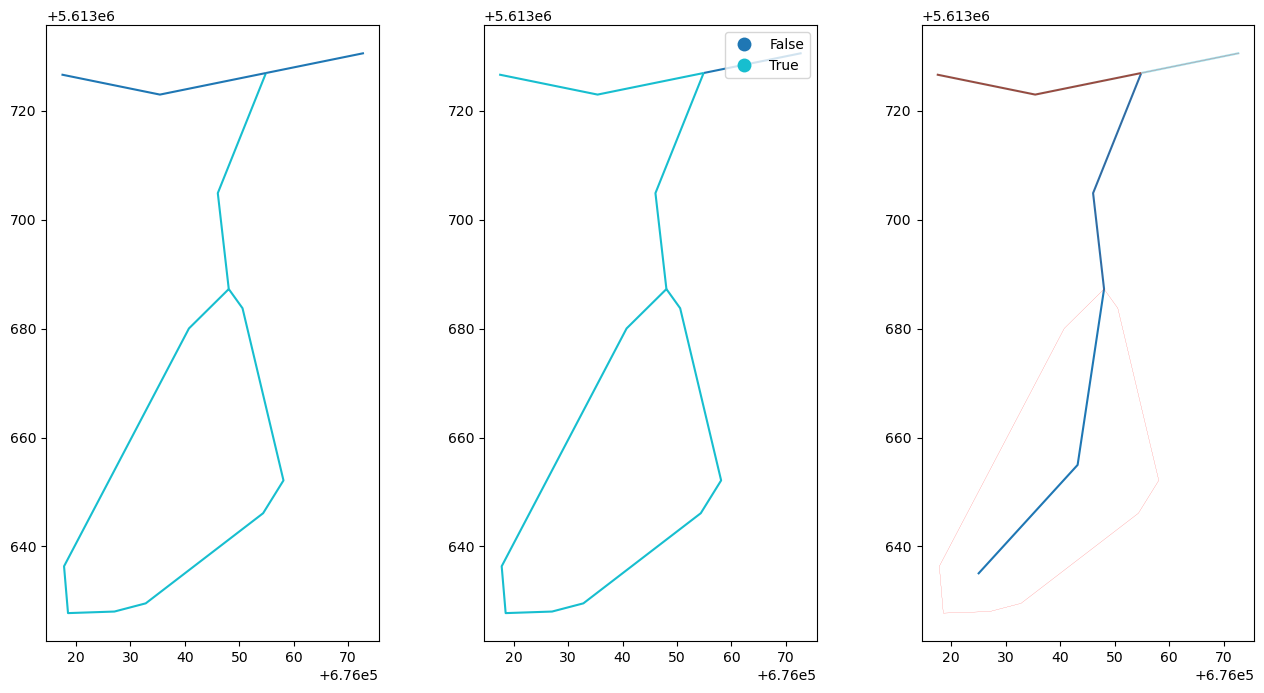

1001


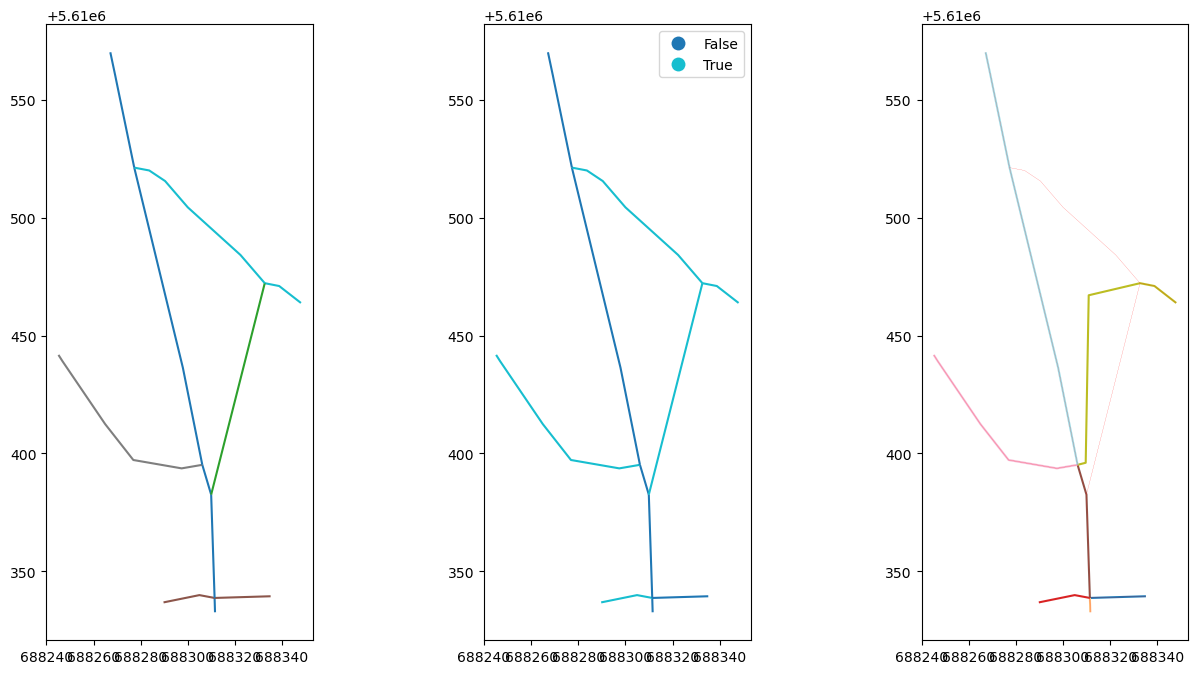

2491


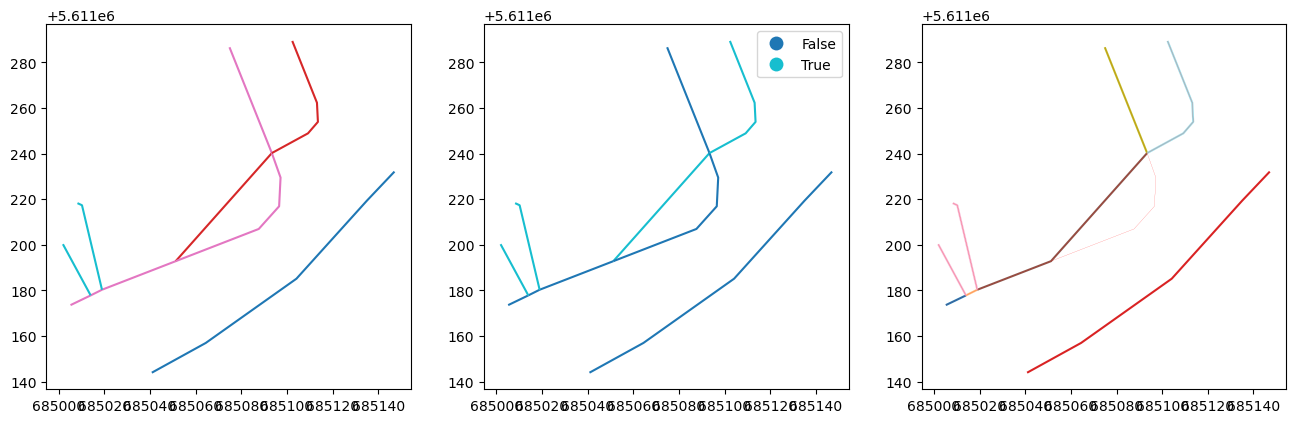

6727


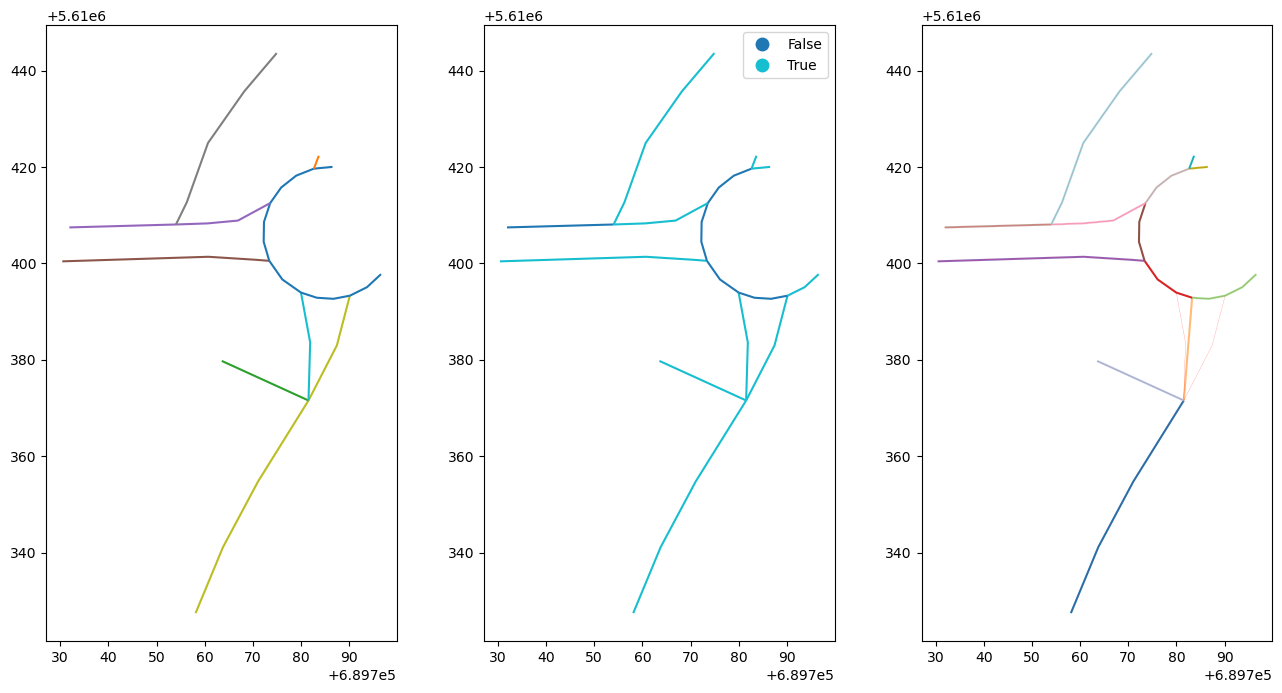

3485


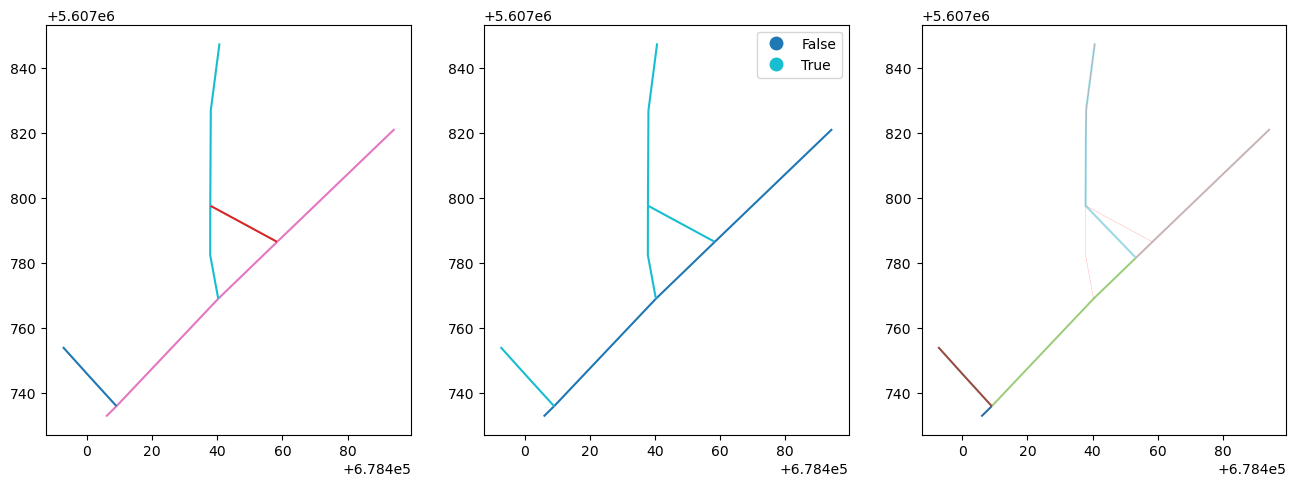

6865


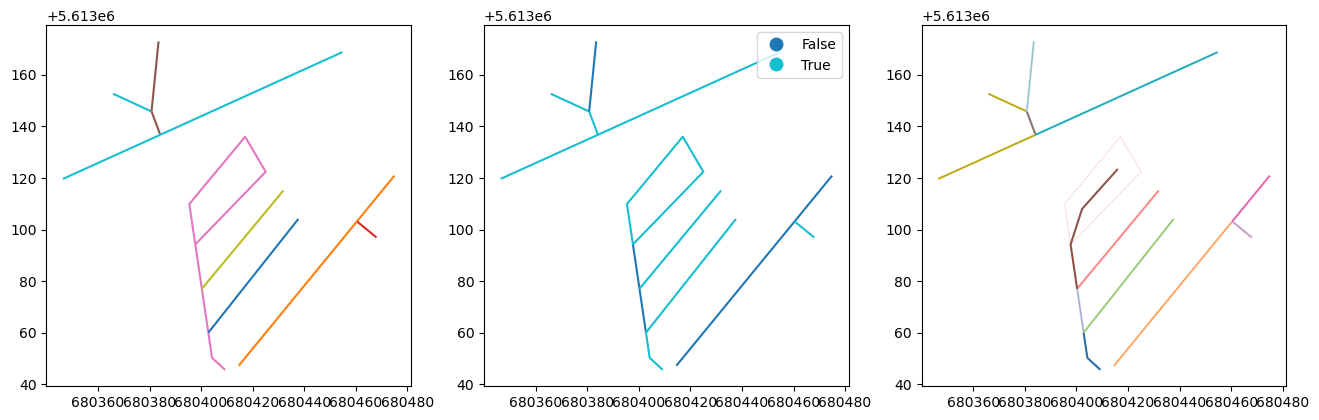

5155


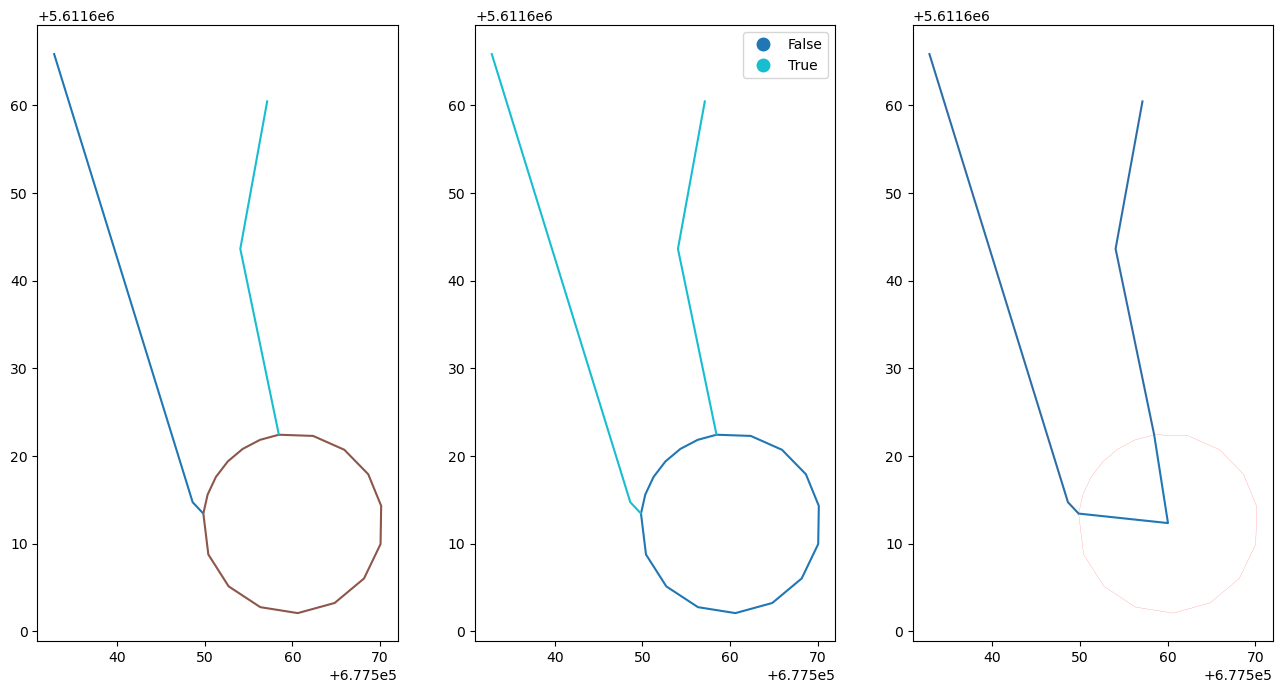

5258


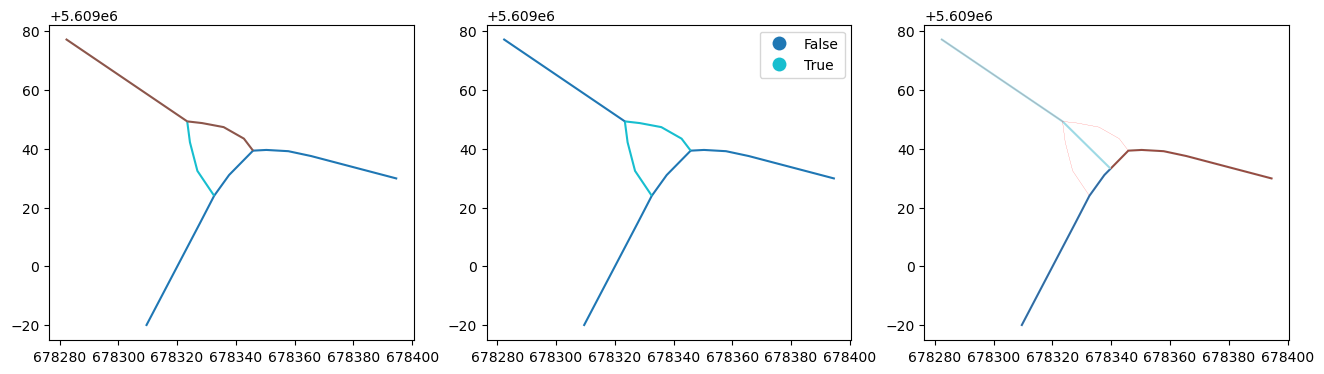

4


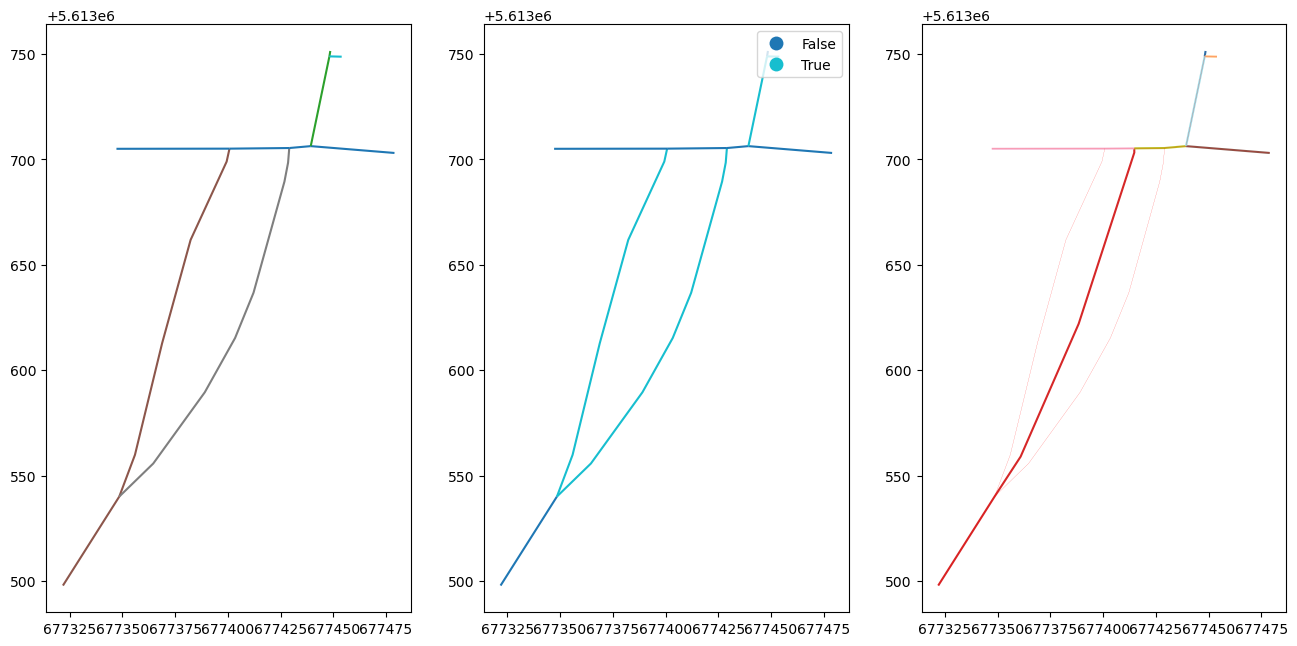

6677


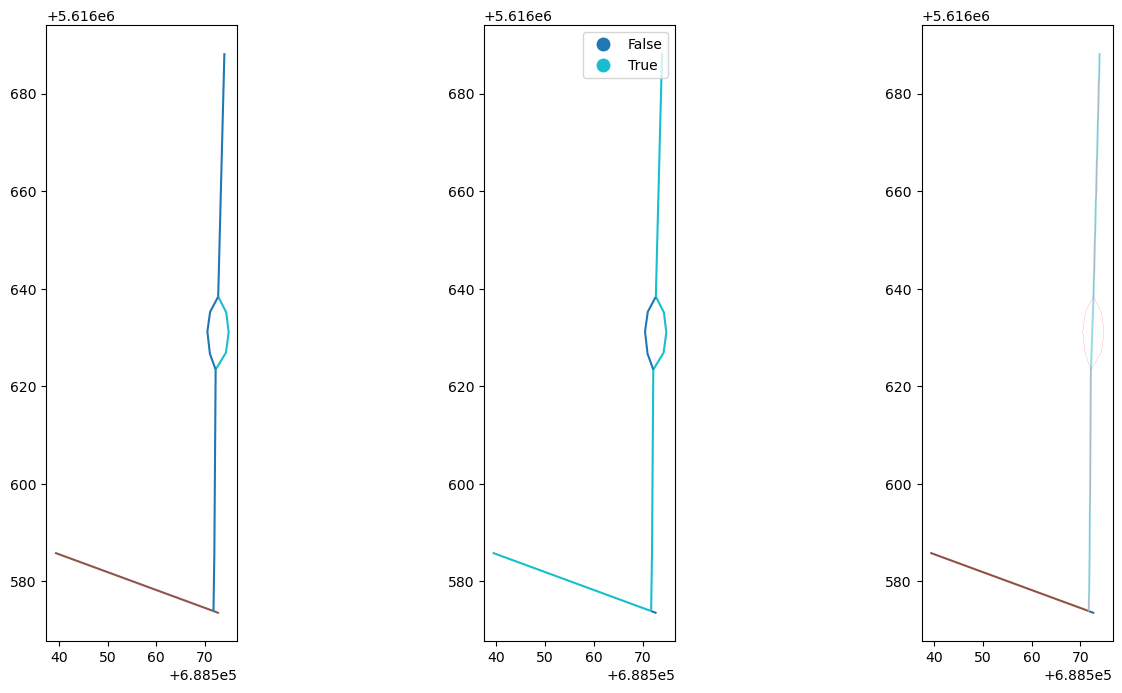

5115


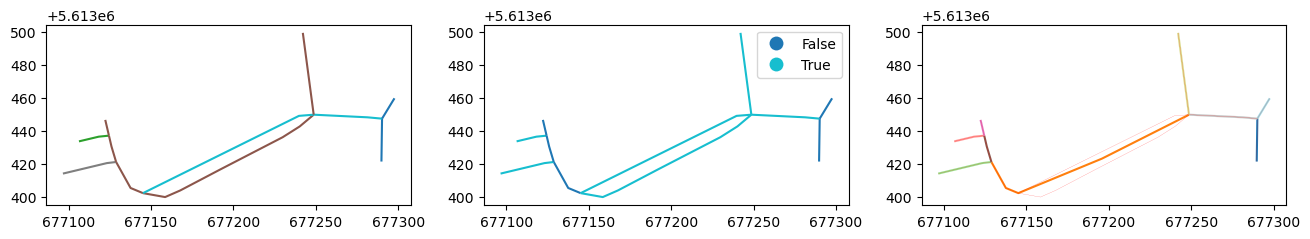

6903


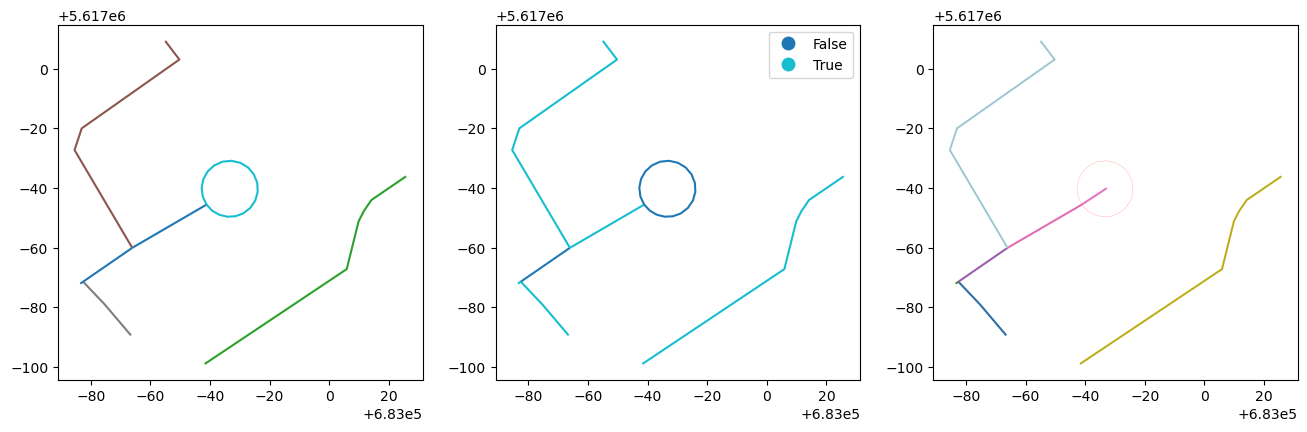

2578


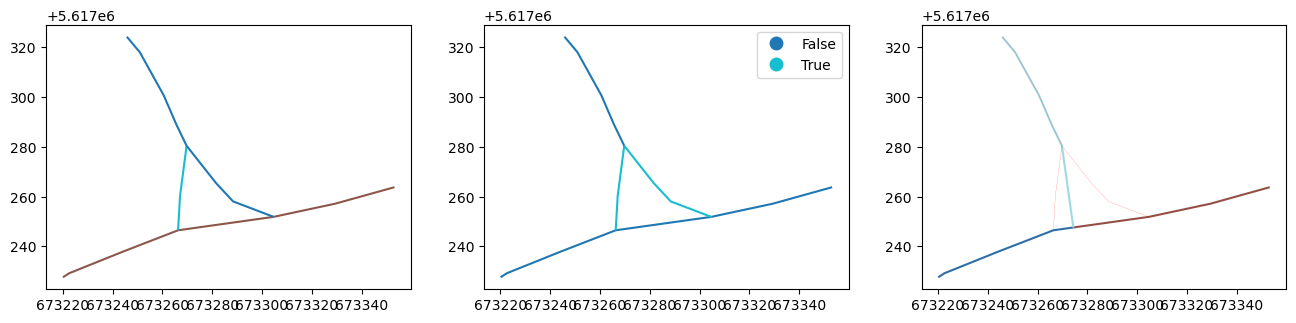

712


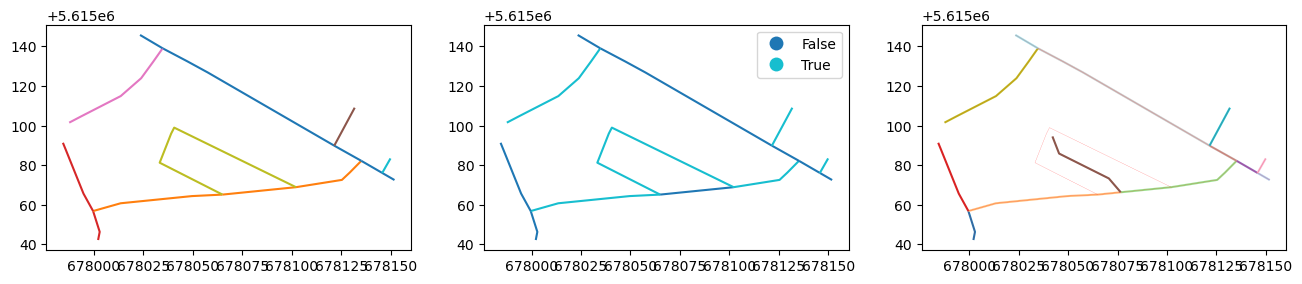

6338


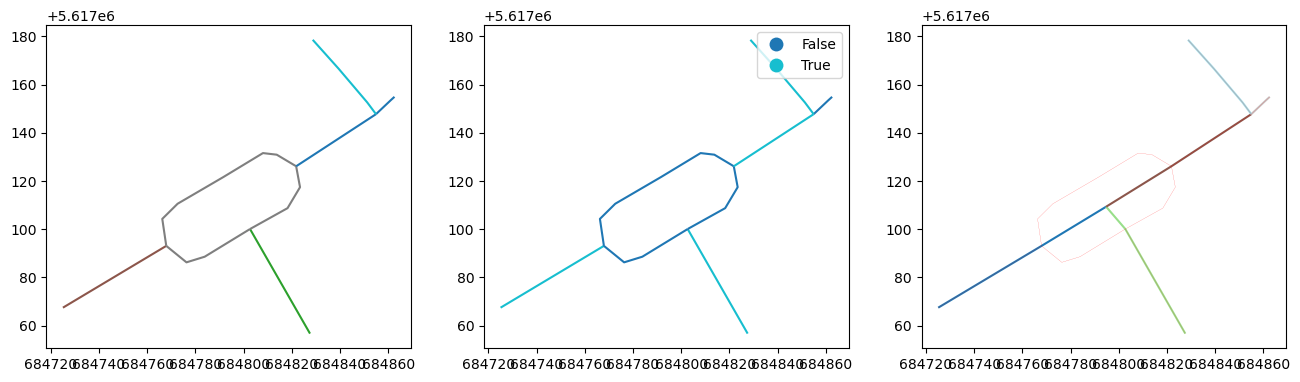

6165


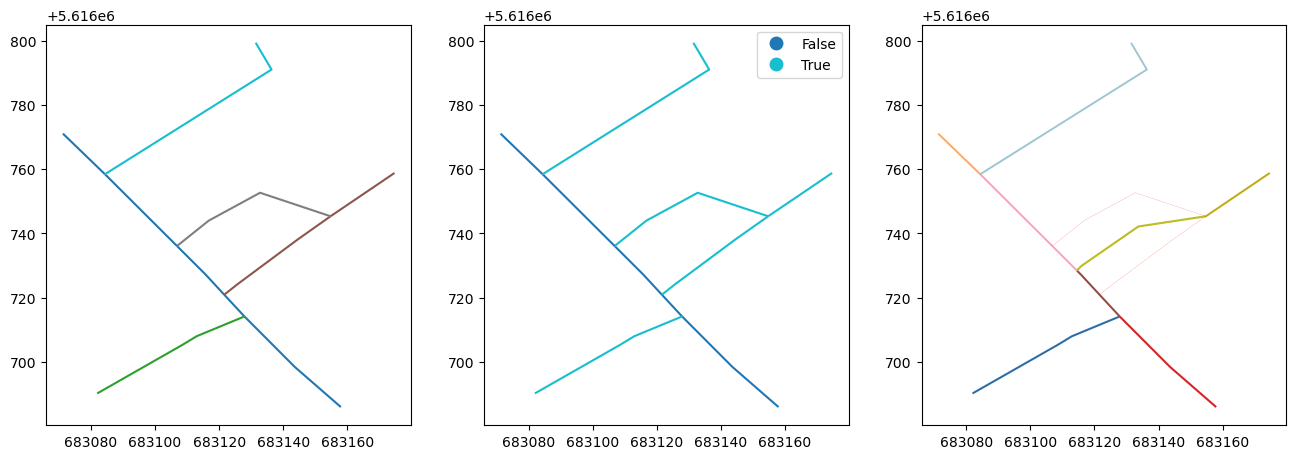

6190


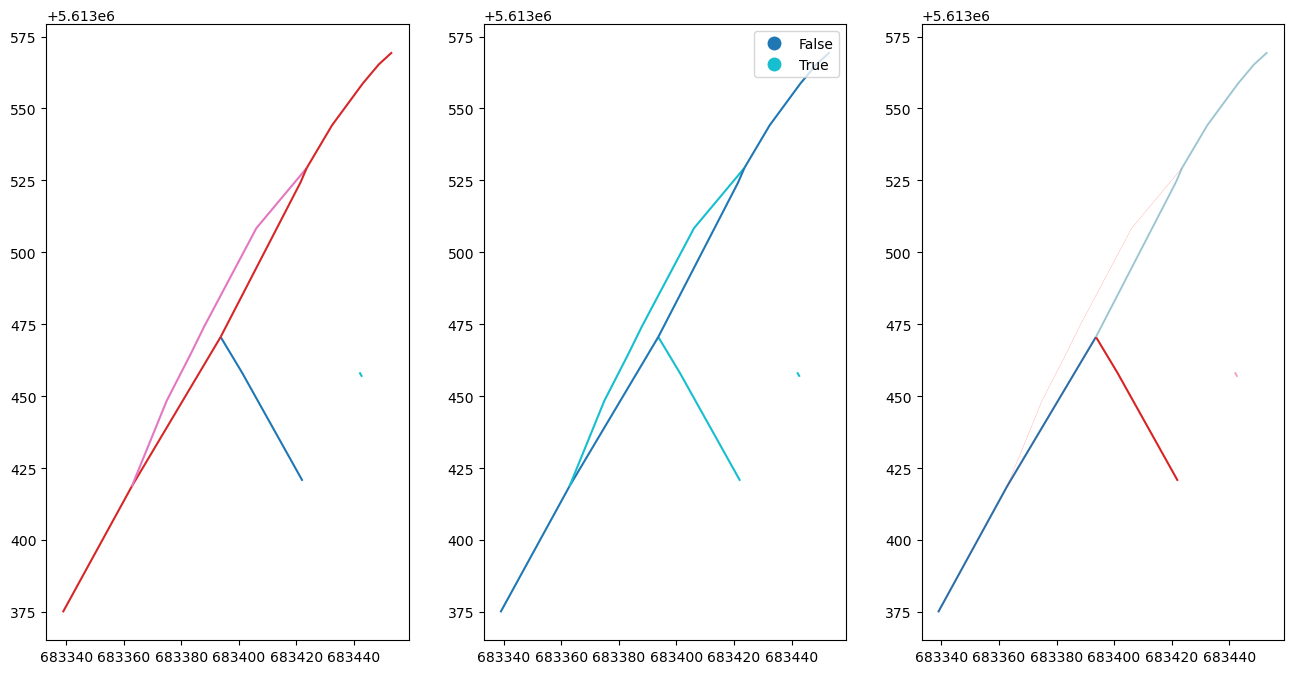

6885


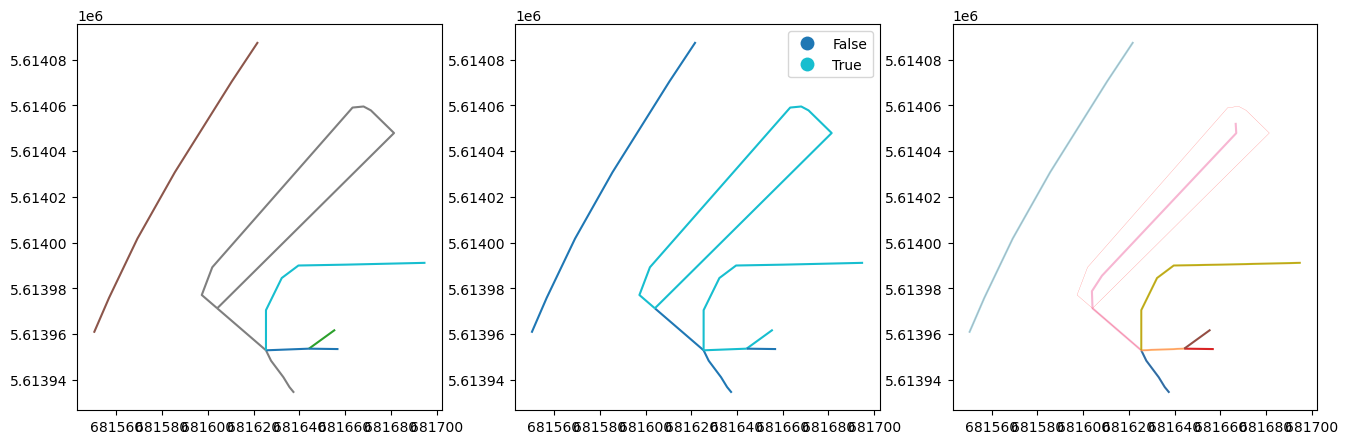

6378


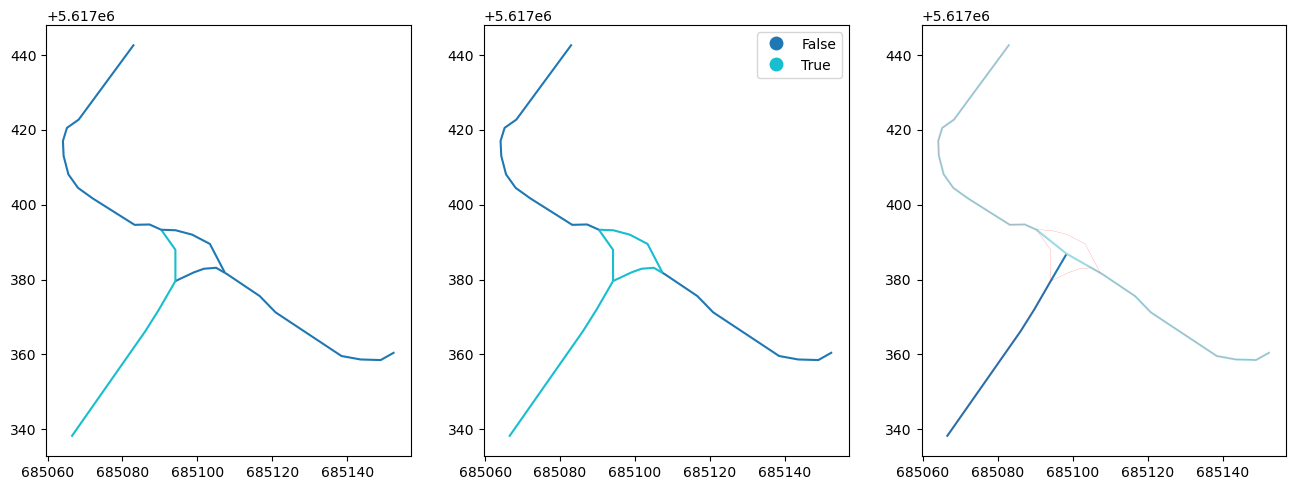

5592


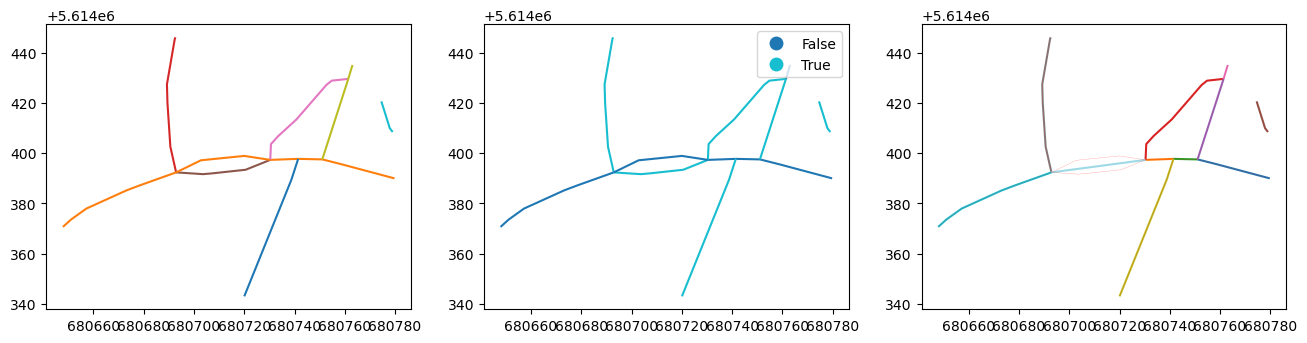

6942


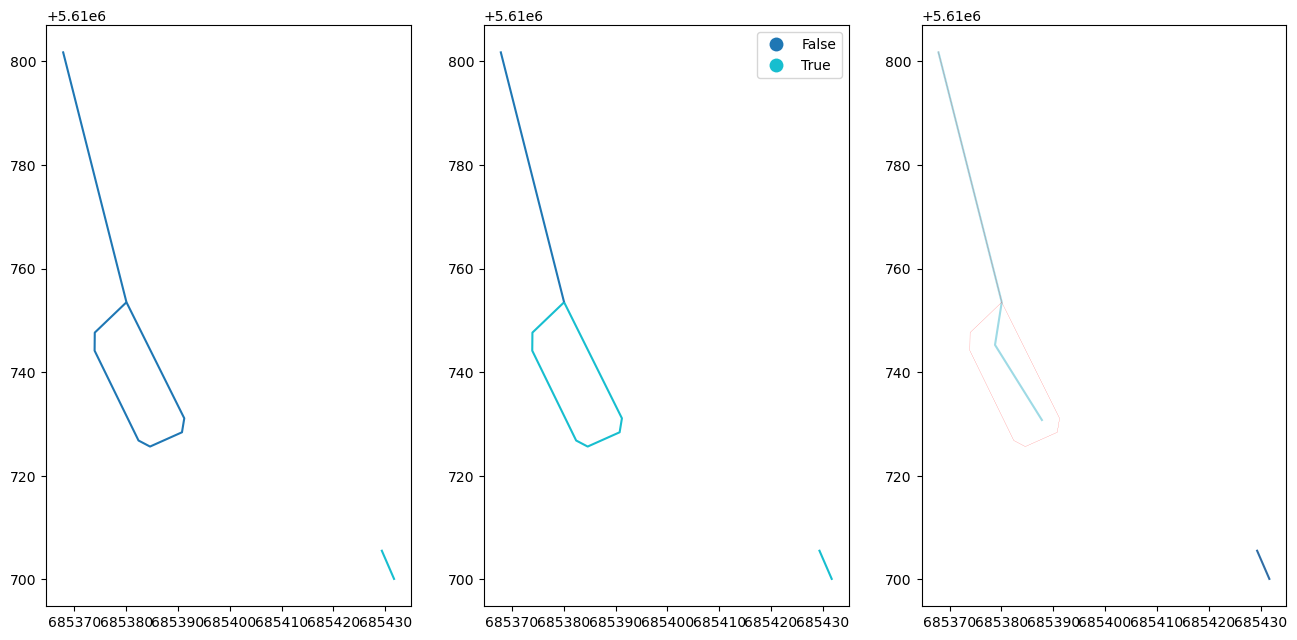

3238


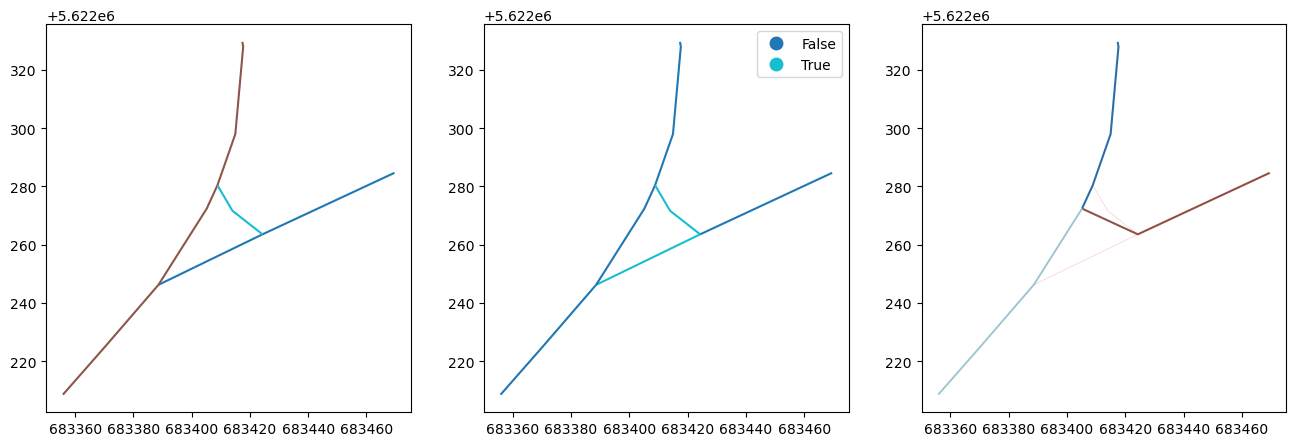

1197


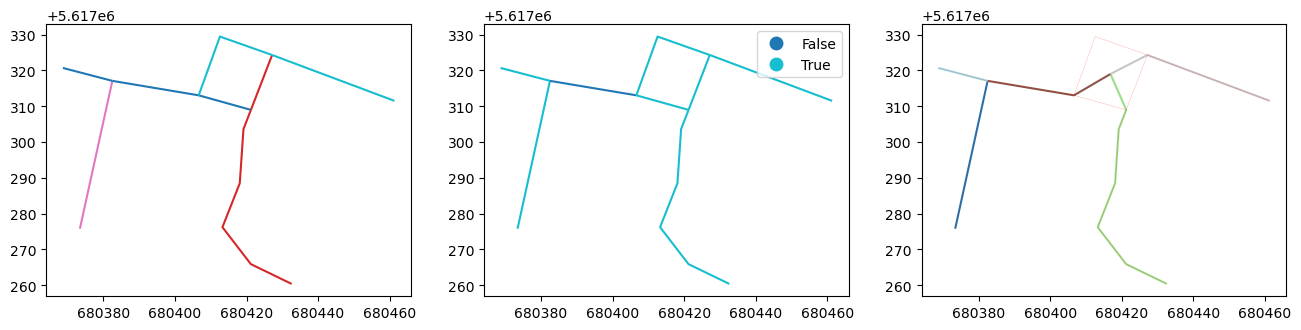

4369


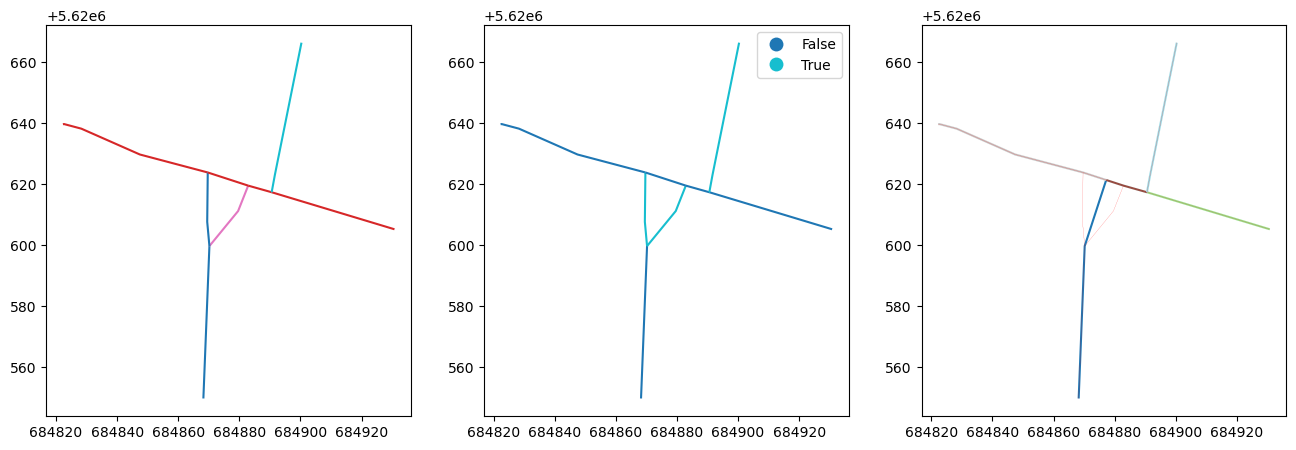

6891


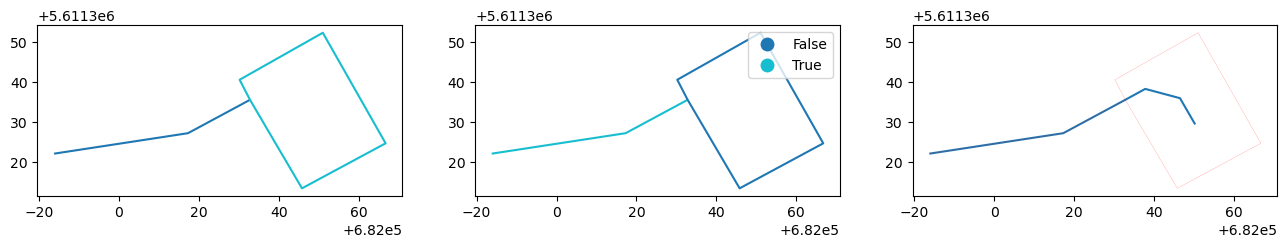

1678


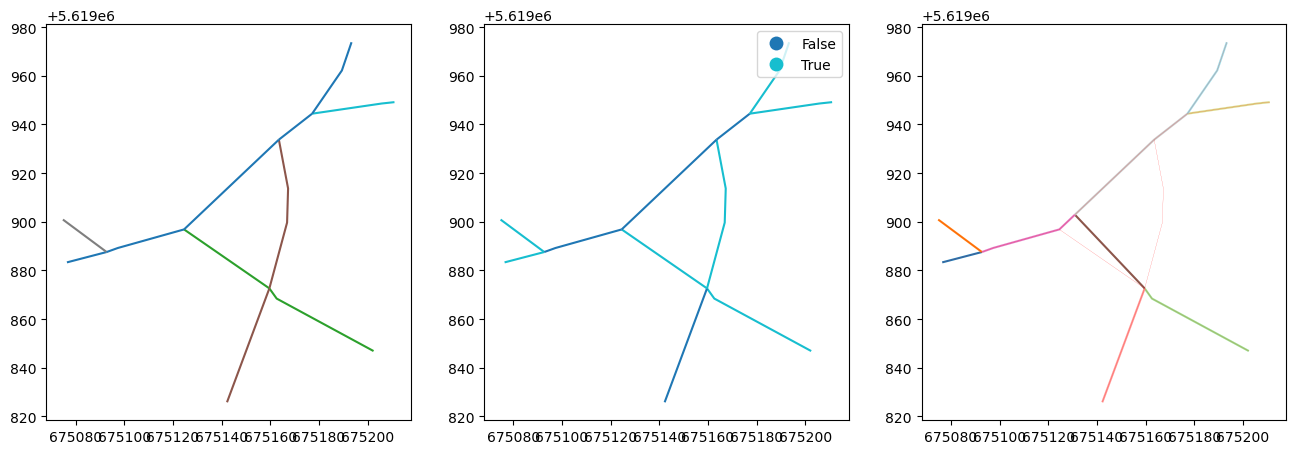

6407


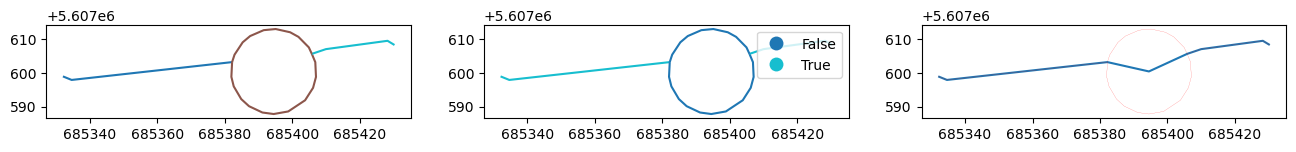

562


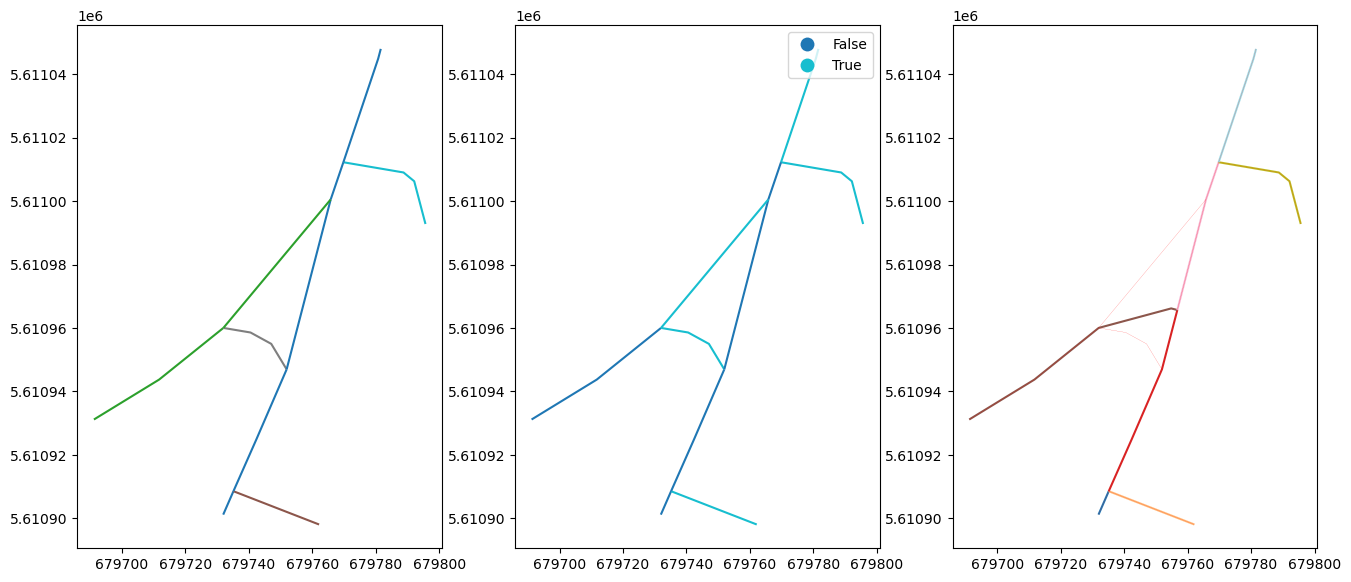

6536


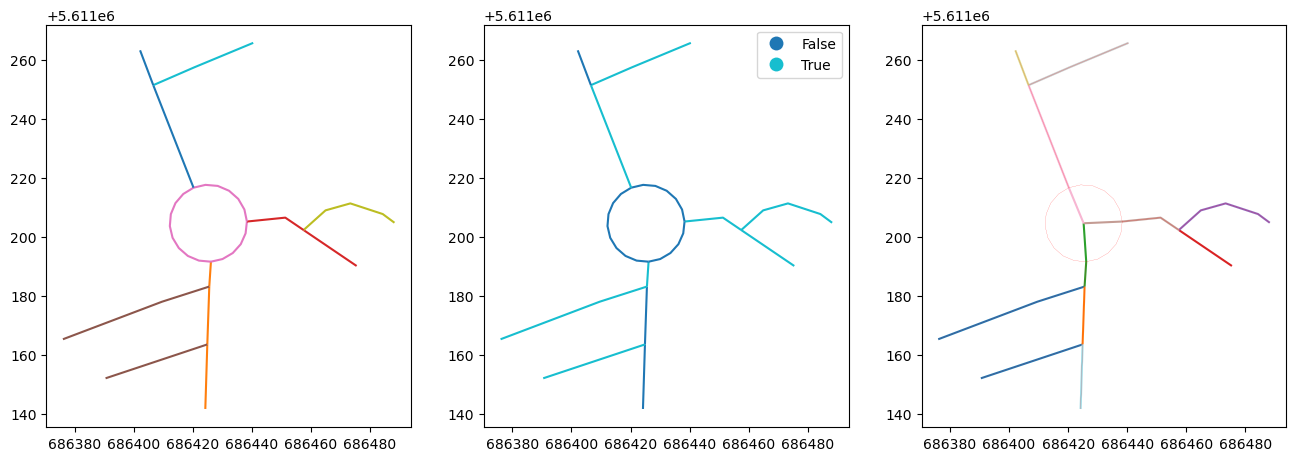

6976


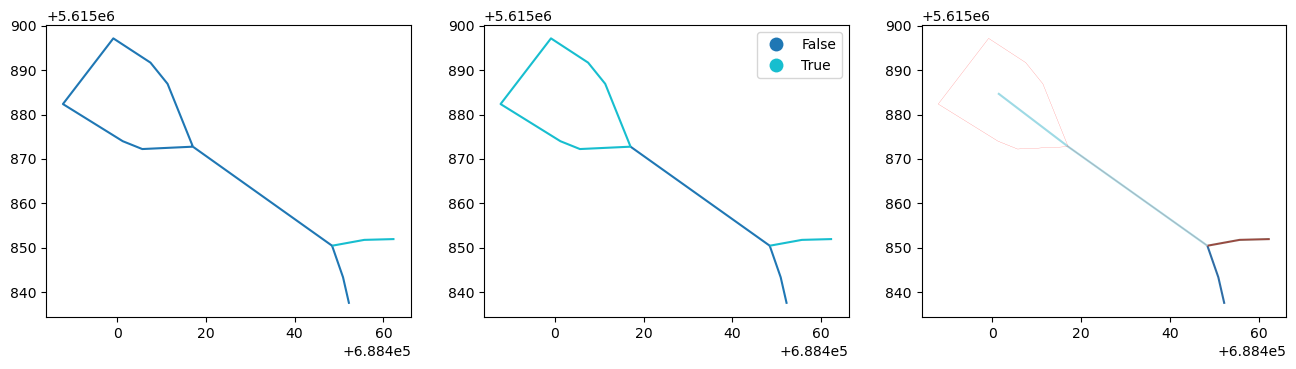

1134


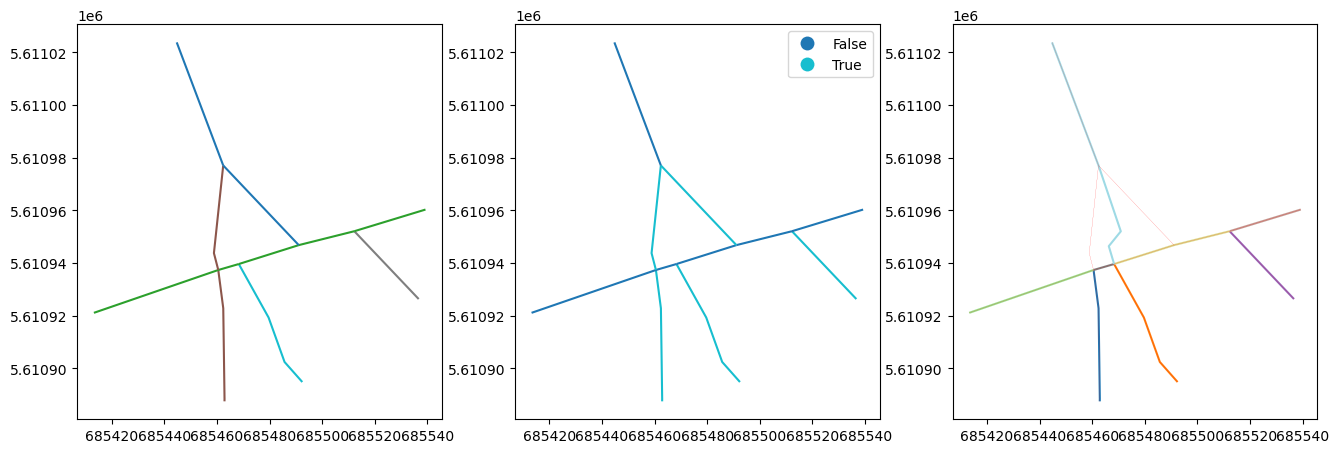

In [20]:
for artifact in data_sample.itertuples():
    print(artifact.Index)

    # plot the results for visual verification
    fig, axs = plt.subplots(1, 3, figsize=(16, 8))
    geom = artifact.geometry
    # geom.plot(hatch="//", ax=axs[0], color="none")
    roads.clip(geom.buffer(50)).plot("coins_group", ax=axs[0], categorical=True)
    # geom.plot(hatch="//", ax=axs[1], color="none")
    roads.clip(geom.buffer(50)).plot(
        "coins_end", ax=axs[1], categorical=True, legend=True
    )
    new_roads.clip(geom.buffer(50)).plot(ax=axs[2], zorder=2, cmap="tab20")
    roads.clip(geom.buffer(50)).plot(
        color="red",
        ax=axs[2],
        # categorical=True,
        # legend=True,
        linewidth=0.1,
    )
    plt.show()

In [21]:
data_sample

,geometry,face_artifact_index,id,node_count,stroke_count,C,E,S,non_planar,interstitial_nodes,ces_type
6872,"POLYGON ((680804.456 5613798.601, 680805.011 5...",5.535109,6872,1,1,0,1,0,False,0,1E
4720,"POLYGON ((667997.411 5614468.475, 667998.348 5...",7.100143,4720,4,1,0,0,1,False,3,4S
4433,"POLYGON ((681209.661 5616502.579, 681193.973 5...",5.359660,4433,2,2,1,0,1,False,0,2CS
3583,"POLYGON ((684494.587 5613162.108, 684483.338 5...",5.590130,3583,4,4,1,2,1,False,0,4CEES
4460,"POLYGON ((683093.03 5612439.758, 683073.8 5612...",5.463205,4460,2,2,1,0,1,False,0,2CS
5697,"POLYGON ((681042.661 5615342.29, 681057.428 56...",5.765600,5697,2,2,0,2,0,False,0,2EE
6314,"POLYGON ((684451.025 5607786.506, 684451.188 5...",5.475219,6314,3,1,0,0,1,False,2,3S
6571,"POLYGON ((686724.137 5617560.975, 686728.747 5...",3.512941,6571,2,2,0,2,0,False,0,2EE
4757,"POLYGON ((669852.942 5619869.865, 669848.37 56...",6.712066,4757,4,1,0,0,1,False,3,4S
6878,"POLYGON ((680957.132 5612046.702, 680956 56120...",5.417771,6878,1,1,0,1,0,False,0,1E
